# Evaluate RAG with LlamaIndex

In this notebook we will look into building an RAG pipeline and evaluating it with LlamaIndex. It has following 3 sections.

1. Understanding Retrieval Augmented Generation (RAG).
2. Building RAG with LlamaIndex.
3. Evaluating RAG with LlamaIndex.

**Retrieval Augmented Generation (RAG)**

LLMs are trained on vast datasets, but these will include your specific data. Retrieval-Augmented Generation (RAG) addresses this by dynamically incorporating your data during the generation process. This is done not by altering the training data of LLMs, but by allowing the model to access and utilize your data in real-time to provide more tailored and contextually relevant responses.

In RAG, your data is loaded and and prepared for queries or “indexed”. User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.

Even if what you’re building is a chatbot or an agent, you’ll want to know RAG techniques for getting data into your application.

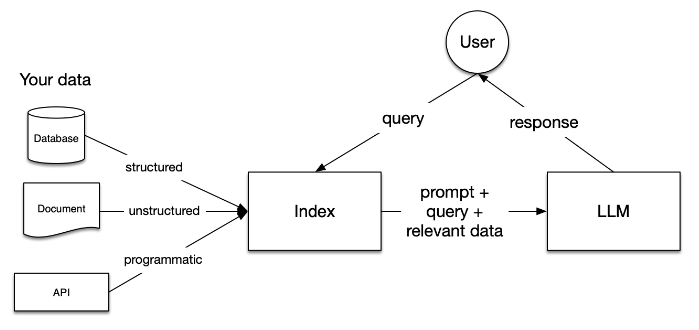

**Stages within RAG**

There are five key stages within RAG, which in turn will be a part of any larger application you build. These are:

**Loading:** this refers to getting your data from where it lives – whether it’s text files, PDFs, another website, a database, or an API – into your pipeline. LlamaHub provides hundreds of connectors to choose from.

**Indexing:** this means creating a data structure that allows for querying the data. For LLMs this nearly always means creating vector embeddings, numerical representations of the meaning of your data, as well as numerous other metadata strategies to make it easy to accurately find contextually relevant data.

**Querying:** for any given indexing strategy there are many ways you can utilize LLMs and LlamaIndex data structures to query, including sub-queries, multi-step queries and hybrid strategies.

**Evaluation:** a critical step in any pipeline is checking how effective it is relative to other strategies, or when you make changes. Evaluation provides objective measures of how accurate, faithful and fast your responses to queries are.

## Build RAG system.

Now that we have understood the significance of RAG system, let's build a simple RAG pipeline.

!pip install llama-index

In [1]:
# The nest_asyncio module enables the nesting of asynchronous functions within an already running async loop.
# This is necessary because Jupyter notebooks inherently operate in an asynchronous loop.
# By applying nest_asyncio, we can run additional async functions within this existing loop without conflicts.
import nest_asyncio

nest_asyncio.apply()

from llama_index.evaluation import generate_question_context_pairs
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.node_parser import SimpleNodeParser
from llama_index.evaluation import generate_question_context_pairs
from llama_index.evaluation import RetrieverEvaluator
from llama_index.llms import OpenAI

import os
import pandas as pd

Set Your OpenAI API Key

In [2]:
os.environ['OPENAI_API_KEY'] = 'YOUR OPENAI API KEY'

Let's use [Paul Graham Essay text](https://www.paulgraham.com/worked.html) for building RAG pipeline.

#### Download Data

In [3]:
!mkdir -p 'data/paul_graham/'
!curl 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -o 'data/paul_graham/paul_graham_essay.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75042  100 75042    0     0   190k      0 --:--:-- --:--:-- --:--:--  190k--:--  0:00:03 24586


#### Load Data and Build Index.

In [4]:
documents = SimpleDirectoryReader("./data/paul_graham/").load_data()

# Define an LLM
llm = OpenAI(model="gpt-4")

# Build index with a chunk_size of 512
node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents)
vector_index = VectorStoreIndex(nodes)

Build a QueryEngine and start querying.

In [5]:
query_engine = vector_index.as_query_engine()

In [6]:
response_vector = query_engine.query("What did the author do growing up?")

Check response.

In [7]:
response_vector.response

'The author wrote short stories and worked on programming, specifically on an IBM 1401 computer using an early version of Fortran.'

By default it retrieves `two` similar nodes/ chunks. You can modify that in `vector_index.as_query_engine(similarity_top_k=k)`.

Let's check the text in each of these retrieved nodes.

In [8]:
# First retrieved node
response_vector.source_nodes[0].get_text()

'What I Worked On\n\nFebruary 2021\n\nBefore college the two main things I worked on, outside of school, were writing and programming. I didn\'t write essays. I wrote what beginning writers were supposed to write then, and probably still are: short stories. My stories were awful. They had hardly any plot, just characters with strong feelings, which I imagined made them deep.\n\nThe first programs I tried writing were on the IBM 1401 that our school district used for what was then called "data processing." This was in 9th grade, so I was 13 or 14. The school district\'s 1401 happened to be in the basement of our junior high school, and my friend Rich Draves and I got permission to use it. It was like a mini Bond villain\'s lair down there, with all these alien-looking machines — CPU, disk drives, printer, card reader — sitting up on a raised floor under bright fluorescent lights.\n\nThe language we used was an early version of Fortran. You had to type programs on punch cards, then stack

In [9]:
# Second retrieved node
response_vector.source_nodes[1].get_text()

"It felt like I was doing life right. I remember that because I was slightly dismayed at how novel it felt. The good news is that I had more moments like this over the next few years.\n\nIn the summer of 2016 we moved to England. We wanted our kids to see what it was like living in another country, and since I was a British citizen by birth, that seemed the obvious choice. We only meant to stay for a year, but we liked it so much that we still live there. So most of Bel was written in England.\n\nIn the fall of 2019, Bel was finally finished. Like McCarthy's original Lisp, it's a spec rather than an implementation, although like McCarthy's Lisp it's a spec expressed as code.\n\nNow that I could write essays again, I wrote a bunch about topics I'd had stacked up. I kept writing essays through 2020, but I also started to think about other things I could work on. How should I choose what to do? Well, how had I chosen what to work on in the past? I wrote an essay for myself to answer that 

We have built a RAG pipeline and now need to evaluate its performance. We can assess our RAG system/query engine using LlamaIndex's core evaluation modules. Let's examine how to leverage these tools to quantify the quality of our retrieval-augmented generation system.

## Evaluation

Evaluation should serve as the primary metric for assessing your RAG application. It determines whether the pipeline will produce accurate responses based on the data sources and a range of queries.

While it's beneficial to examine individual queries and responses at the start, this approach may become impractical as the volume of edge cases and failures increases. Instead, it may be more effective to establish a suite of summary metrics or automated evaluations. These tools can provide insights into overall system performance and indicate specific areas that may require closer scrutiny.

In a RAG system, evaluation focuses on two critical aspects:

*   **Retrieval Evaluation:** This assesses the accuracy and relevance of the information retrieved by the system.
*   **Response Evaluation:** This measures the quality and appropriateness of the responses generated by the system based on the retrieved information.

#### Question-Context Pair Generation:

For the evaluation of a RAG system, it's essential to have queries that can fetch the correct context and subsequently generate an appropriate response. `LlamaIndex` offers a `generate_question_context_pairs` module specifically for crafting questions and context pairs which can be used in the assessment of the RAG system of both Retrieval and Response Evaluation. For more details on Question Generation, please refer to the [documentation](https://docs.llamaindex.ai/en/stable/examples/evaluation/QuestionGeneration.html).

In [10]:
qa_dataset = generate_question_context_pairs(
    nodes,
    llm=llm,
    num_questions_per_chunk=2
)

100%|██████████| 58/58 [06:26<00:00,  6.67s/it]


#### Retrieval Evaluation:

We are now prepared to conduct our retrieval evaluations. We will execute our `RetrieverEvaluator` using the evaluation dataset we have generated.

We first create the `Retriever` and then define two functions: `get_eval_results`, which operates our retriever on the dataset, and `display_results`, which presents the outcomes of the evaluation.

Let's create the retriever.

In [11]:
retriever = vector_index.as_retriever(similarity_top_k=2)

Define `RetrieverEvaluator`. We use **Hit Rate** and **MRR** metrics to evaluate our Retriever.

**Hit Rate:**

Hit rate calculates the fraction of queries where the correct answer is found within the top-k retrieved documents. In simpler terms, it’s about how often our system gets it right within the top few guesses.

**Mean Reciprocal Rank (MRR):**

For each query, MRR evaluates the system’s accuracy by looking at the rank of the highest-placed relevant document. Specifically, it’s the average of the reciprocals of these ranks across all the queries. So, if the first relevant document is the top result, the reciprocal rank is 1; if it’s second, the reciprocal rank is 1/2, and so on.

Let's check these metrics to check the performance of out retriever.

In [12]:
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

In [13]:
# Evaluate
eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

Let's define a function to display the Retrieval evaluation results in table format.

In [14]:
def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()

    metric_df = pd.DataFrame(
        {"Retriever Name": [name], "Hit Rate": [hit_rate], "MRR": [mrr]}
    )

    return metric_df

In [15]:
display_results("OpenAI Embedding Retriever", eval_results)

,Retriever Name,Hit Rate,MRR
0,OpenAI Embedding Retriever,0.758621,0.62069


#### Observation:

The Retriever with OpenAI Embedding  demonstrates a performance with a hit rate of `0.7586`, while the MRR, at `0.6206`, suggests there's room for improvement in ensuring the most relevant results appear at the top. The observation that MRR is less than the hit rate indicates that the top-ranking results aren't always the most relevant. Enhancing MRR could involve the use of rerankers, which refine the order of retrieved documents. For a deeper understanding of how rerankers can optimize retrieval metrics, refer to the detailed discussion in our [blog post](https://blog.llamaindex.ai/boosting-rag-picking-the-best-embedding-reranker-models-42d079022e83).

#### Response Evaluation:

1. FaithfulnessEvaluator: Measures if the response from a query engine matches any source nodes which is useful for measuring if the response is hallucinated.
2. Relevancy Evaluator: Measures if the response + source nodes match the query.

In [16]:
# Get the list of queries from the above created dataset

queries = list(qa_dataset.queries.values())

#### Faithfulness Evaluator

Let's start with FaithfulnessEvaluator.

We will use `gpt-3.5-turbo` for generating response for a given query and `gpt-4` for evaluation.

Let's create service_context seperately for `gpt-3.5-turbo` and `gpt-4`.

In [17]:
# gpt-3.5-turbo
gpt35 = OpenAI(temperature=0, model="gpt-3.5-turbo")
service_context_gpt35 = ServiceContext.from_defaults(llm=gpt35)

# gpt-4
gpt4 = OpenAI(temperature=0, model="gpt-4")
service_context_gpt4 = ServiceContext.from_defaults(llm=gpt4)

Create a `QueryEngine` with `gpt-3.5-turbo` service_context to generate response for the query.

In [18]:
vector_index = VectorStoreIndex(nodes, service_context = service_context_gpt35)
query_engine = vector_index.as_query_engine()

Create a  FaithfulnessEvaluator.




In [19]:
from llama_index.evaluation import FaithfulnessEvaluator
faithfulness_gpt4 = FaithfulnessEvaluator(service_context=service_context_gpt4)

Let's evaluate on the first question.

In [20]:
eval_query = queries[10]

eval_query

"Based on the author's experience and observations, why did he consider the AI practices during his first year of grad school as a hoax? Provide specific examples from the text to support your answer."

Generate response first and use faithfull evaluator.

In [21]:
response_vector = query_engine.query(eval_query)

In [22]:
# Compute faithfulness evaluation

eval_result = faithfulness_gpt4.evaluate_response(response=response_vector)

In [23]:
# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

True

#### Relevancy Evaluator

RelevancyEvaluator is useful to measure if the response and source nodes (retrieved context) match the query. Useful to see if response actually answers the query.

Instantiate `RelevancyEvaluator` for relevancy evaluation with `gpt-4`

In [24]:
from llama_index.evaluation import RelevancyEvaluator

relevancy_gpt4 = RelevancyEvaluator(service_context=service_context_gpt4)

Let's do relevancy evaluation for one of the query.

In [25]:
# Pick first query
query = queries[10]

query

"Based on the author's experience and observations, why did he consider the AI practices during his first year of grad school as a hoax? Provide specific examples from the text to support your answer."

In [26]:
# Generate response.
# response_vector has response and source nodes (retrieved context)
response_vector = query_engine.query(query)

# Relevancy evaluation
eval_result = relevancy_gpt4.evaluate_response(
    query=query, response=response_vector
)

In [27]:
# You can check passing parameter in eval_result if it passed the evaluation.
eval_result.passing

True

In [28]:
# You can get the feedback for the evaluation.
eval_result.feedback

'YES'

#### Batch Evaluator:

Now that we have done FaithFulness and Relevancy Evaluation independently. LlamaIndex has `BatchEvalRunner` to compute multiple evaluations in batch wise manner.

In [29]:
from llama_index.evaluation import BatchEvalRunner

# Let's pick top 10 queries to do evaluation
batch_eval_queries = queries[:10]

# Initiate BatchEvalRunner to compute FaithFulness and Relevancy Evaluation.
runner = BatchEvalRunner(
    {"faithfulness": faithfulness_gpt4, "relevancy": relevancy_gpt4},
    workers=8,
)

# Compute evaluation
eval_results = await runner.aevaluate_queries(
    query_engine, queries=batch_eval_queries
)

In [30]:
# Let's get faithfulness score

faithfulness_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['faithfulness'])

faithfulness_score

1.0

In [31]:
# Let's get relevancy score

relevancy_score = sum(result.passing for result in eval_results['faithfulness']) / len(eval_results['relevancy'])

relevancy_score


1.0

#### Observation:

Faithfulness score of `1.0` signifies that the generated answers contain no hallucinations and are entirely based on retrieved context.

Relevancy score of `1.0` suggests that the answers generated are consistently aligned with the retrieved context and the queries.

There are many other different evaluation modules in LlamaIndex and you can check them [here](https://docs.llamaindex.ai/en/stable/module_guides/evaluating/root.html)